## 1. import

In [3]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

## 2. Data

데이터 리스트 출력

In [6]:
file_list = os.listdir("./data")
file_list

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']

#### 2.1 Meta csv파일 확인

dataframe으로 불러오기

In [50]:
import pandas as pd
df_meta =  pd.read_csv('./data/Meta.csv')
df_meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


Meta png 요소
classid - 각 표지판 고유번호 
shapedId - 0 : 삼각형
           1 : 동그라미
           2 : 역삼각형
           3 : 마름모
           4 : 육각형
colorid - 빨검(기본 0으로)
          파 (1)
          노 (2)
          검 (3)

 교통표지판 데이터   
 Meta_image, Meta_label

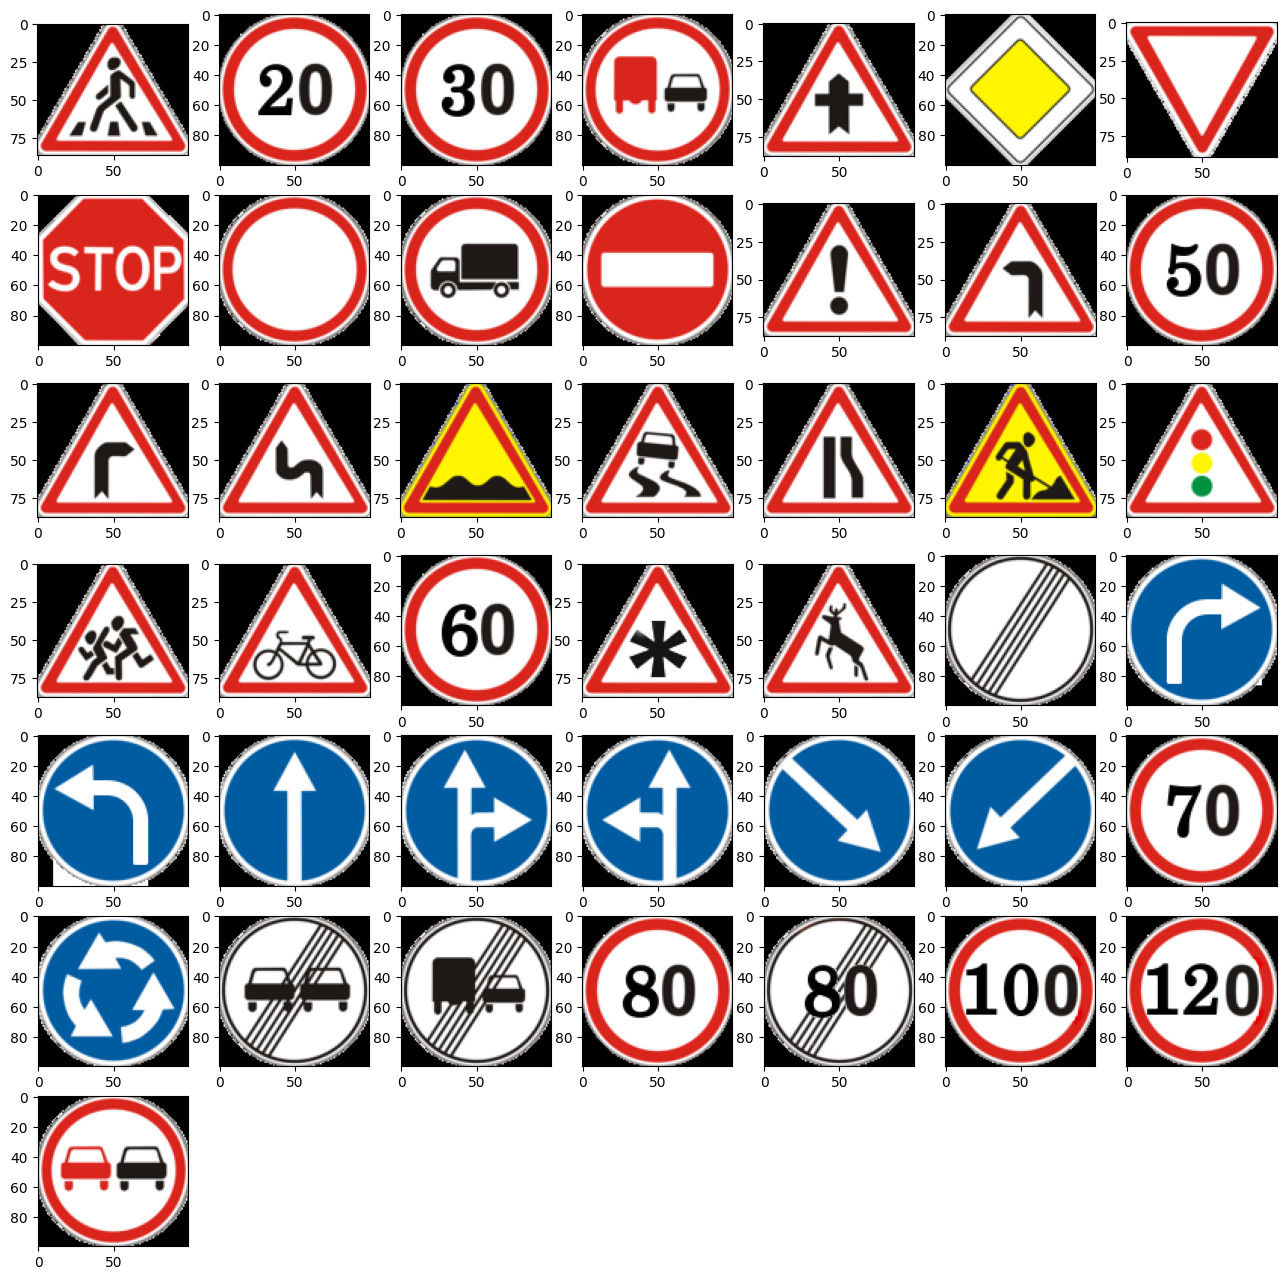

In [51]:
Meta_images = []
Meta_labels = []

plt.figure(figsize=(16,16))
for i in range(len(df)):
    img = load_img('./data/'+df['Path'][i])
    plt.subplot(7, 7, i+1)
    plt.imshow(img)
    Meta_images.append(df_meta['Path'][i])     #파일이름
    Meta_labels.append(df_meta['ClassId'][i])  #ClassId=label로

#### 2.2 train csv파일 확인

In [52]:
df_train = pd.read_csv('./data/Train.csv')
df_train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


가로 픽셀수 분포도

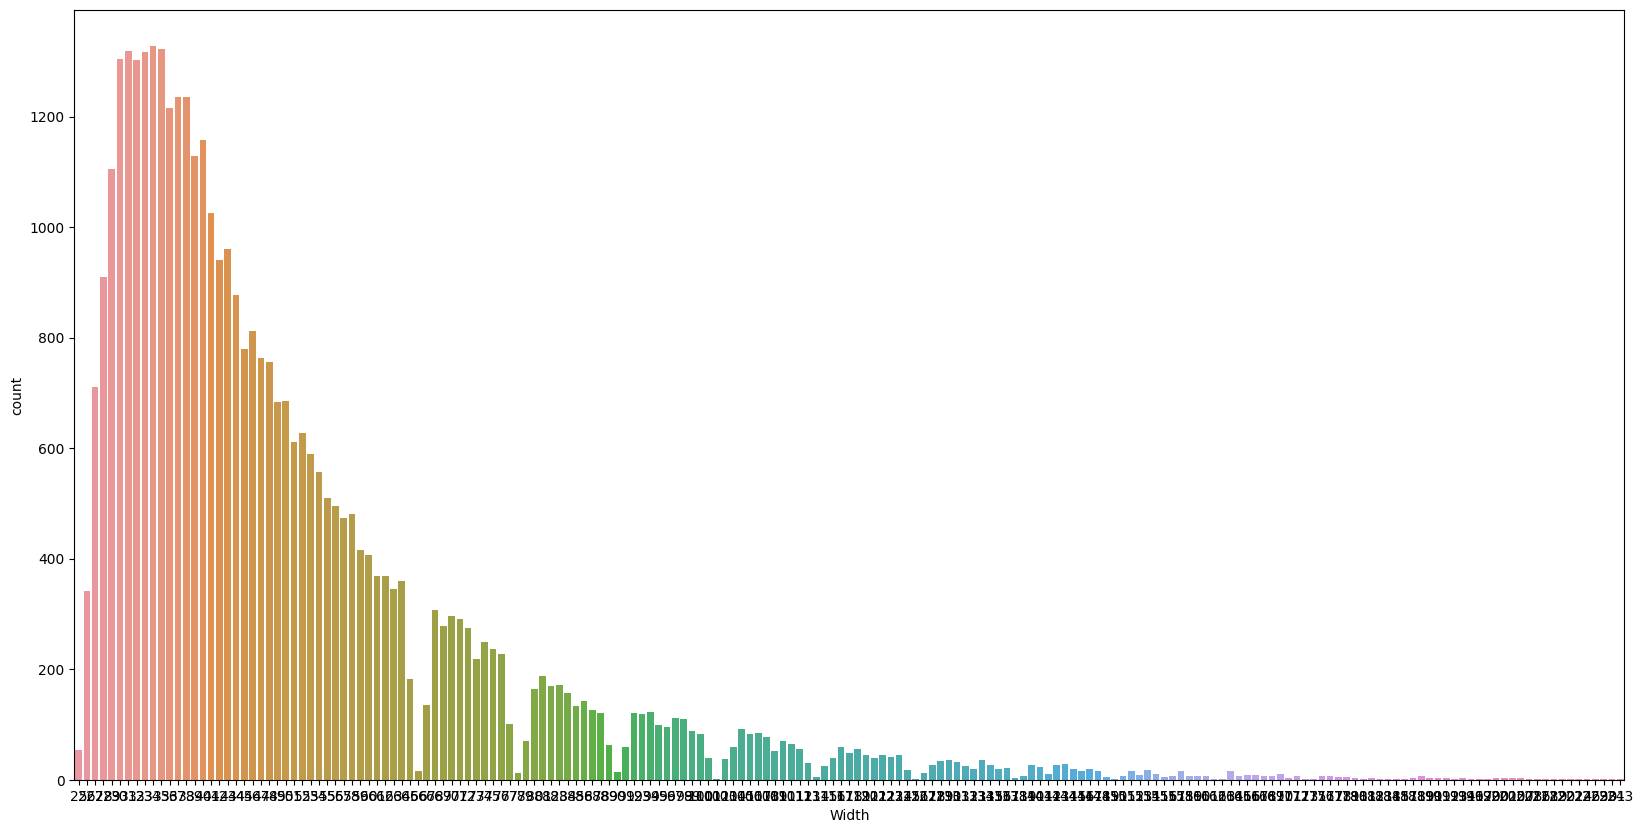

In [54]:
#seaborn 사용
import seaborn as sns
plt.figure(figsize=(20,10))
ax = sns.countplot(x="Width",data=df_train)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24012\2083473794.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


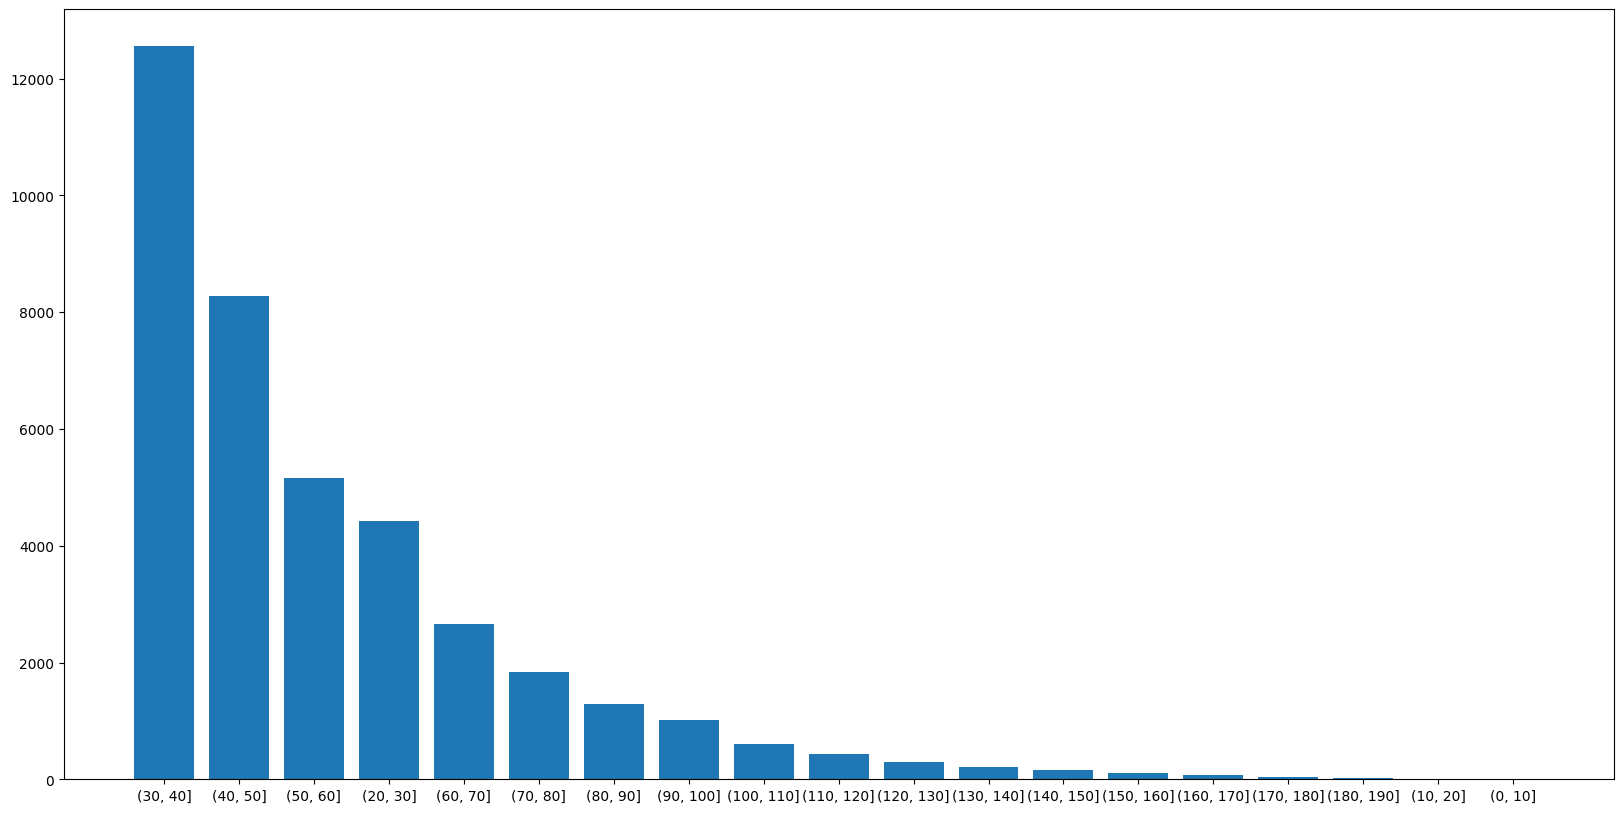

In [62]:
#matbplotlib사용
df_cutWidth = pd.cut(df_train['Width'], np.arange(0,200,10)).value_counts(sort=True) #0~200사이를 10단위로쪼갬, 젤 많은크기로 정렬
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(df_cutWidth)), df_cutWidth.values)
ax.set_xticks(range(len(df_cutWidth)))
ax.set_xticklabels(df_cutWidth.index)
fig.show()

30~40크기를 갖는 분포가 가장 많기때문에
이미지 크기를 33x33으로 동일하게 함.

In [63]:
image_height = 33
image_width = 33
image_channel = 3

Roi 데이터 : 표지판이 있는 부분을 의미
  > 좌측상단 좌표 우측하단 좌표를 의미함

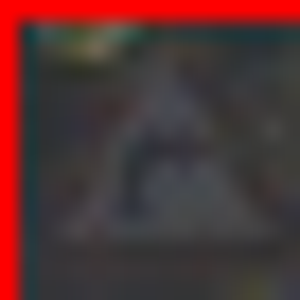

In [77]:
from PIL import Image
from PIL import ImageDraw

img_sample = Image.open('./data/'+df_train['Path'][0])
draw = ImageDraw.Draw(img_sample)

draw.rectangle([df_train['Roi.X1'][0],df_train['Roi.Y1'][0],df_train['Roi.X2'][0],df_train['Roi.Y2'][0]], outline= "red")
#resize
img_sample_resize = img_sample.resize((300,300))
#crop
img_sample_crop = img_sample.crop([df_train['Roi.X1'][0],df_train['Roi.Y1'][0],df_train['Roi.X2'][0],df_train['Roi.Y2'][0]])
img_sample_crop = img_sample_crop.resize((300,300))
img_sample_crop

#### 2.3 test csv파일 확인

In [84]:
df_test = pd.read_csv('./data/test.csv')
df_test